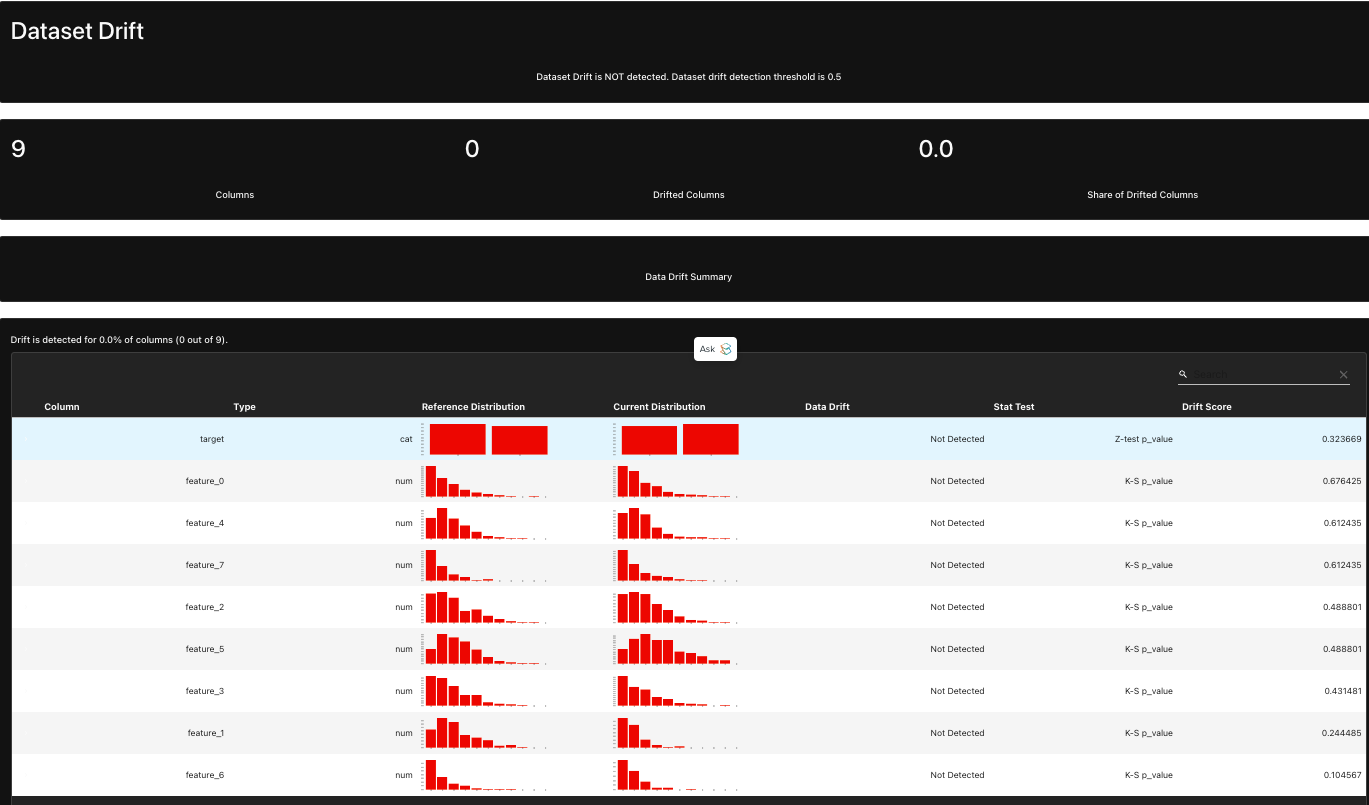

In [1]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install evidently

# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [2]:
from datasets import load_dataset
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt

# Load the dataset from Hugging Face
dataset = load_dataset("WriLee/alient_predator")

# Show the total number of items in the dataset (before splitting)
print(f"Total number of items in the dataset: {dataset['train'].num_rows}")

# Assuming the dataset has a 'train' split; adjust if it has a different structure
data = dataset['train'].shuffle(seed=42)  # seed is optional for reproducibility

# Convert to a Pandas DataFrame for easier manipulation
df = pd.DataFrame({'image': data['image'], 'label': data['label']})


# Split into reference and current datasets (e.g., 50-50 split)
reference_df = df.iloc[:len(df)//2]  # First half as reference
current_df = df.iloc[len(df)//2:]    # Second half as current

# Show the number of rows in the reference and current DataFrames
print(f"Number of rows in reference_df: {len(reference_df)}")
print(f"Number of rows in current_df: {len(current_df)}")

Total number of items in the dataset: 694
Number of rows in reference_df: 347
Number of rows in current_df: 347


In [3]:
reference_df

image  label
0    <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
1    <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
2    <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
3    <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
4    <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
..                                                 ...    ...
342  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
343  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
344  <PIL.PngImagePlugin.PngImageFile image mode=P ...      0
345  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
346  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1

[347 rows x 2 columns]

In [4]:
current_df

image  label
347  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
348  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
349  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
350  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
351  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
..                                                 ...    ...
689  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
690  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
691  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
692  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
693  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1

[347 rows x 2 columns]

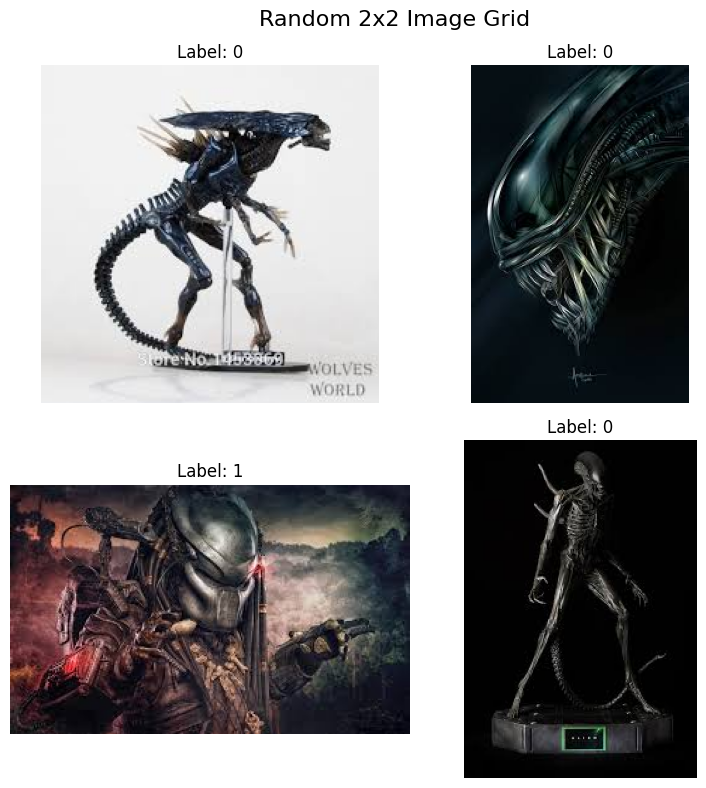

In [5]:
from datasets import load_dataset
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt

# Function to display a 2x2 grid of random images from a DataFrame
def display_random_2x2_grid(dataframe):
    # Select 4 random indices (ensure there are at least 4 images)
    if len(dataframe) < 4:
        raise ValueError("DataFrame must contain at least 4 images.")
    random_indices = random.sample(range(len(dataframe)), 4)
    
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle("Random 2x2 Image Grid", fontsize=16)
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Populate the grid with random images
    for i, idx in enumerate(random_indices):
        image = dataframe.iloc[idx]['image']
        label = dataframe.iloc[idx]['label']
        
        # If the image is a dictionary (e.g., from Hugging Face), extract the actual image
        if isinstance(image, dict):
            image = Image.open(image['path'])  # Adjust based on dataset structure
        
        # Display the image in the subplot
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')  # Hide axes
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example: Display a 2x2 grid from the current_df
display_random_2x2_grid(current_df)


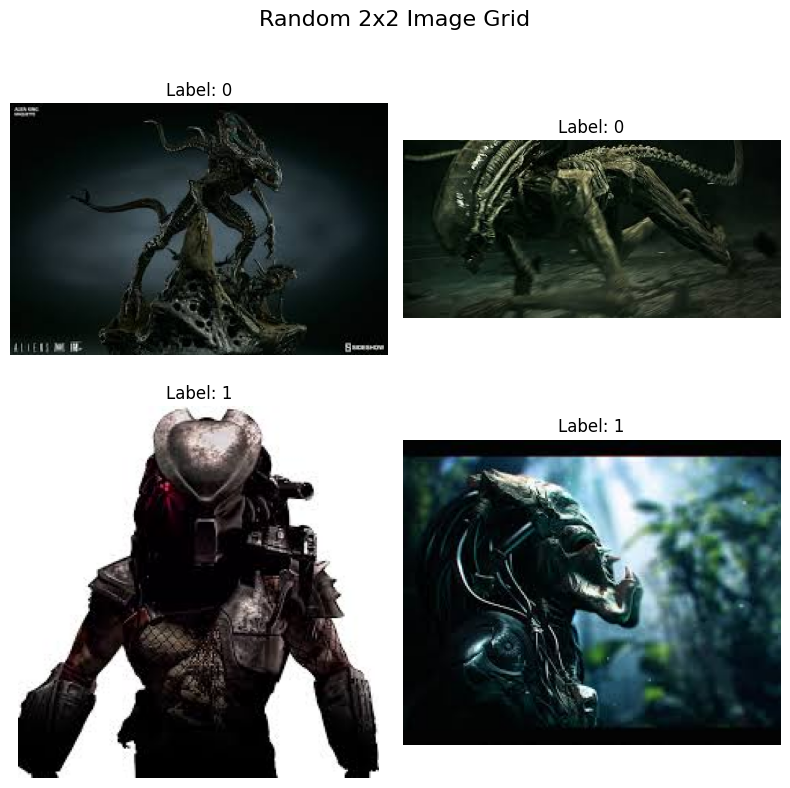

In [6]:

# Example: Display a 2x2 grid from the reference_df
display_random_2x2_grid(reference_df)

#  Extract Features from Images



Since Evidently works with tabular data, we need to extract numerical features from the images. A common approach is to use a pre-trained convolutional neural network (CNN) like ResNet to generate image embeddings.



In [7]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet model and move it to the selected device
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = model.to(device)  # Move model to GPU if available
model.eval()  # Set to evaluation mode

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
reference_df

image  label
0    <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
1    <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
2    <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
3    <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
4    <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
..                                                 ...    ...
342  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
343  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
344  <PIL.PngImagePlugin.PngImageFile image mode=P ...      0
345  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1
346  <PIL.JpegImagePlugin.JpegImageFile image mode=...      1

[347 rows x 2 columns]

In [9]:

feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer

# Define image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features from an image
def extract_image_features(image):
    if isinstance(image, str):  # If image is a file path
        image = Image.open(image).convert('RGB')
    else:  # Assuming image is a PIL Image
        image = image.convert('RGB')
    
    input_tensor = preprocess(image).unsqueeze(0)
    # Move tensor to the same device as model
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():
        features = feature_extractor(input_tensor)
        # Move features back to CPU and convert to numpy
        features = features.squeeze().cpu().numpy()
    return features

# Extract features for reference and current datasets
reference_df['features'] = reference_df['image'].apply(extract_image_features)
current_df['features'] = current_df['image'].apply(extract_image_features)

/tmp/ipykernel_874/3068579838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_df['features'] = reference_df['image'].apply(extract_image_features)
/tmp/ipykernel_874/3068579838.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['features'] = current_df['image'].apply(extract_image_features)


# Prepare Data for Evidently
Evidently expects tabular data, so we’ll convert the feature arrays into separate columns (e.g., feature_0, feature_1, ..., feature_2047). We’ll also include the labels.



In [10]:
# Convert feature arrays into separate columns
reference_features = pd.DataFrame(reference_df['features'].tolist(), 
                                 columns=[f'feature_{i}' for i in range(2048)], 
                                 index=reference_df.index)
current_features = pd.DataFrame(current_df['features'].tolist(), 
                                columns=[f'feature_{i}' for i in range(2048)], 
                                index=current_df.index)


In [11]:

# Combine features with labels
reference_df = pd.concat([reference_features, reference_df['label'].rename('target')], axis=1)
current_df = pd.concat([current_features, current_df['label'].rename('target')], axis=1)

In [13]:
reference_df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0     0.861529   0.374434   0.422740   0.302809   0.329252   0.400064   
1     0.035963   0.054774   0.231600   0.443349   0.317058   0.604755   
2     0.038400   0.967608   0.192873   0.279506   0.408416   0.199600   
3     0.116002   0.267817   0.156717   0.459982   0.414370   0.913720   
4     0.290354   1.242941   0.094621   0.231027   0.655566   0.638300   
..         ...        ...        ...        ...        ...        ...   
342   0.061172   0.266376   0.129497   0.576540   0.274275   0.130231   
343   0.157436   0.339279   0.010857   0.353375   0.327119   0.375793   
344   1.035894   1.556968   0.155679   0.032179   0.338054   0.795778   
345   0.158361   0.254622   0.426637   0.338636   0.192537   0.476315   
346   0.177263   0.140934   0.189190   0.867968   0.344481   0.795097   

     feature_6  feature_7  feature_8  feature_9  ...  feature_2039  \
0     0.676388   0.357066   1.027309   0.595561  ...      0.689894   
1     0.041164   0.060954   0.274374   0.141033  ...      0.154200   
2     1.343271   0.691048   0.155278   0.317944  ...      1.690820   
3     0.092628   0.749821   0.255675   0.385805  ...      1.199551   
4     0.151060   0.141584   0.410025   0.415952  ...      0.046578   
..         ...        ...        ...        ...  ...           ...   
342   0.205326   0.049804   0.042758   1.047517  ...      0.551925   
343   0.055505   0.182899   0.331393   0.067240  ...      0.490576   
344   0.116656   0.191108   0.944991   0.345178  ...      0.312160   
345   0.840297   0.400312   0.665890   0.295001  ...      0.566949   
346   0.072154   0.042299   0.105060   0.229233  ...      0.086090   

     feature_2040  feature_2041  feature_2042  feature_2043  feature_2044  \
0        0.206164      0.816487      0.792535      0.368360      0.518787   
1        0.003123      0.084729      0.004169      0.113524      0.498696   
2        0.167849      0.273179      0.448571      0.090456      1.757950   
3        1.344504      0.469420      0.295615      0.315299      0.468383   
4        0.712970      0.680241      0.307494      0.248173      0.382739   
..            ...           ...           ...           ...           ...   
342      0.461871      0.032360      0.147188      0.201704      0.550350   
343      0.423617      0.339005      0.001654      0.265008      0.308816   
344      0.483457      0.914600      0.623724      0.189172      0.034793   
345      0.736175      0.255345      0.308090      0.221525      0.044672   
346      0.198588      0.039115      0.111136      0.409469      0.011746   

     feature_2045  feature_2046  feature_2047  target  
0        0.361369      0.617837      0.076017       0  
1        0.573363      0.093804      0.343216       1  
2        0.413253      0.449984      0.056294       1  
3        0.392328      0.184568      0.309868       1  
4        1.442872      0.672603      0.513969       0  
..            ...           ...           ...     ...  
342      0.812816      0.059675      0.170676       1  
343      0.515829      0.386604      0.339296       0  
344      0.622125      1.233792      0.134317       0  
345      0.486144      0.249969      0.456613       1  
346      1.423942      1.161940      0.034172       1  

[347 rows x 2049 columns]

In [14]:
current_df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
347   0.480832   1.008729   0.230360   0.073317   0.579919   1.185554   
348   0.111522   0.571101   0.516755   0.092094   0.240571   1.178391   
349   0.751022   0.906232   0.463099   0.172316   0.386341   0.060267   
350   0.225792   0.326699   0.138959   0.003913   0.093393   0.906772   
351   0.176834   0.067211   0.194591   0.524452   0.366493   0.348406   
..         ...        ...        ...        ...        ...        ...   
689   0.048110   0.201909   0.268868   0.344664   0.056728   0.000000   
690   0.366149   1.122581   0.024878   0.015464   0.151390   0.694171   
691   0.087353   0.446401   0.545860   0.096768   0.392135   0.366254   
692   0.012467   0.056222   0.080226   0.458800   0.271589   0.316311   
693   0.143084   0.134455   0.741407   0.469810   0.063088   0.426864   

     feature_6  feature_7  feature_8  feature_9  ...  feature_2039  \
347   0.023308   0.291252   0.124230   0.141491  ...      0.047337   
348   0.001101   0.642442   0.321068   0.281397  ...      0.568702   
349   0.078631   0.009131   0.932853   0.086552  ...      0.197490   
350   0.084805   0.093295   0.581095   0.161992  ...      0.751303   
351   0.015298   0.077172   0.612167   0.122761  ...      1.804197   
..         ...        ...        ...        ...  ...           ...   
689   0.014857   0.385921   0.384765   0.100719  ...      0.419465   
690   0.019724   0.021680   1.081088   0.117578  ...      0.012495   
691   0.097806   0.242715   0.531522   0.408786  ...      0.255058   
692   0.277162   0.233685   0.148213   0.130519  ...      1.155069   
693   0.182754   0.220164   0.269358   0.935860  ...      0.845679   

     feature_2040  feature_2041  feature_2042  feature_2043  feature_2044  \
347      0.326804      0.987248      0.098079      0.337170      0.040164   
348      0.537805      0.246615      0.076567      0.181151      0.107696   
349      0.208521      0.600858      0.257100      0.129048      0.196966   
350      1.453998      0.566419      0.072365      0.221239      0.615462   
351      0.017725      0.128615      0.171037      0.086575      0.196920   
..            ...           ...           ...           ...           ...   
689      1.368969      0.044445      0.206225      0.008537      0.099989   
690      0.090707      0.161009      0.150237      0.088993      0.278376   
691      0.524168      0.803174      0.049623      0.172765      0.277167   
692      0.499103      0.301114      0.658521      0.148157      0.399297   
693      0.290949      0.276148      0.077730      0.109261      0.272695   

     feature_2045  feature_2046  feature_2047  target  
347      0.322329      0.376832      0.677040       0  
348      0.823098      0.239562      0.551774       1  
349      0.865018      0.765244      0.246146       0  
350      0.392169      0.604568      0.266995       0  
351      0.548925      0.080114      0.258655       1  
..            ...           ...           ...     ...  
689      0.501352      0.352508      0.024978       1  
690      0.085911      0.130701      0.177106       0  
691      1.082461      0.055098      0.785653       1  
692      0.599150      0.330253      0.098725       1  
693      0.504600      0.032966      0.340003       1  

[347 rows x 2049 columns]

In [30]:
selected_column = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4','feature_5', 'feature_6', 'feature_7']
selected_column

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7']

In [31]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently import ColumnMapping

# Define column mapping
column_mapping = ColumnMapping()
column_mapping.target = 'target'  # Labels as the target
column_mapping.numerical_features = selected_column # Image features

# Create and run the Evidently report
report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=reference_df, current_data=current_df, column_mapping=column_mapping)

# Save the report as an HTML file
report.save_html("data_drift_report.html")

In [32]:

from IPython.display import display, HTML

# Read and display the HTML content
with open("data_drift_report.html", 'r', encoding='utf-8') as f:
    html_content = f.read()
display(HTML(html_content))